# Clustering of cadastral parcels

In [1]:
from mygeodb.geodatabase import Geodatabase as gdb

In [9]:
import pandas as pd

In [2]:
buffer=20

In [3]:
db=gdb(f'/home/yoba/Projects/kad-clustering/output/clustering-{buffer}.sqlite')

In [4]:
db.attach('/home/yoba/NVMe/DataScience/data/Open-Data/kad_buildings/output/kad_buildings.sqlite','kad')

## Parcels selection

Select links between parcels *from Walloon Brabant* whose PointOnSurface are no more than 100m apart.

In [5]:
db.database.execute('drop table if exists t06_parcels_connections_bw_100m')
db.database.execute('''
create table t06_parcels_connections_bw_100m as
select capakey_a as a,
       capakey_b as b
from kad.t06_parcels_connections
where substr(capakey_a,1,2)='25' and st_length(geometry)<100
''')

Count number of lines in `t06_parcels_connections_bw_100m`

In [6]:
db.getTableCountOfRows('t06_parcels_connections_bw_100m')

2823531

Let's have a look at a sample from `t06_parcels_connections_bw_100m`

In [12]:
pd.read_sql('select * from t06_parcels_connections_bw_100m order by random() limit 10',db.database)

a                  b
0  25056B0157/00F002  25056B0170/00W002
1  25783E0023/00L003  25783E0023/00M004
2  25782C0417/00B002  25782C0412/00A006
3  25056B0336/00W005  25056B0355/00D000
4  25062C0202/00G000  25062B0290/00M000
5  25105B0421/00T005  25105B0421/00T005
6  25112D0227/00B000  25112D0223/00L000
7  25023A0102/00W002  25023A0102/00P002
8  25055A0420/00B000  25055A0421/00F000
9  25014A0473/00Y000  25014A0473/00H000

View of all links between from a given parcel

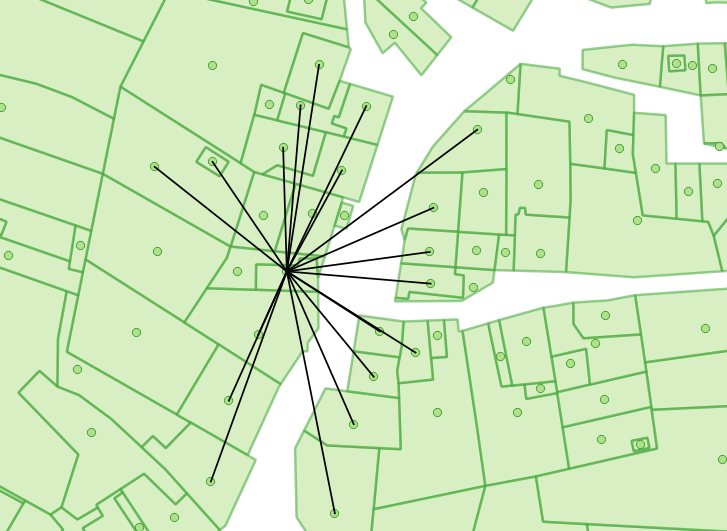

# Label connected components

t06_parcels_connections_bw_100m is a graph. As I don't consider the direction of the links, you can consider it as a undirected graph. Let's identify the connected components of this undirected graph.


In [13]:
db.findConnectedComponents('t06_parcels_connections_bw_100m',['a','b'],'t09_cc')

id      cc
0       25782D0752/00S000  116254
1       25064A0294/00E000   93249
2       25022B0384/00P000       2
3       25006A0389/00T000  134901
4       25782C0079/00D002  116254
...                   ...     ...
149066  25083D0101/00H000   52837
149067  25394D0321/00T000   15045
149068  25744P0832/00_000   28121
149069  25386B0065/16_000   40264
149070  25021A0015/00L000   50696

[149071 rows x 2 columns]

Count number of row in `t06_parcels_connections_bw_100m`. It is equal to the count of parcels in Walloon Brabant.

In [8]:
db.getTableCountOfRows('t09_cc')

149071

# Create polygons

A cluster is the union of all polygons that are linked with one another, ie, the union of constituants of a connected component.

In [14]:
t10_connected_components='''

select dropTable(NULL,'t10_connected_components',1);

create table t10_connected_components as
select cc, castToMultiPolygon(st_union(geometry)) as geometry
from (
        select  parcels.capakey, cc.cc, parcels.geometry
        from kad.t04_agdp_parcels parcels INNER JOIN t09_cc cc
        on cc.id=parcels.capakey
        order by cc.cc
     )
group by cc;

create unique index i10_connected_components on t10_connected_components(cc);

'''

In [15]:
# %% Build sectors

db.database.executescript(t10_connected_components)
db.recoverGeometry('t10_connected_components')
db.createSpatialIndex('t10_connected_components')

Here is the representation of a few connected components. Each components has its own color.

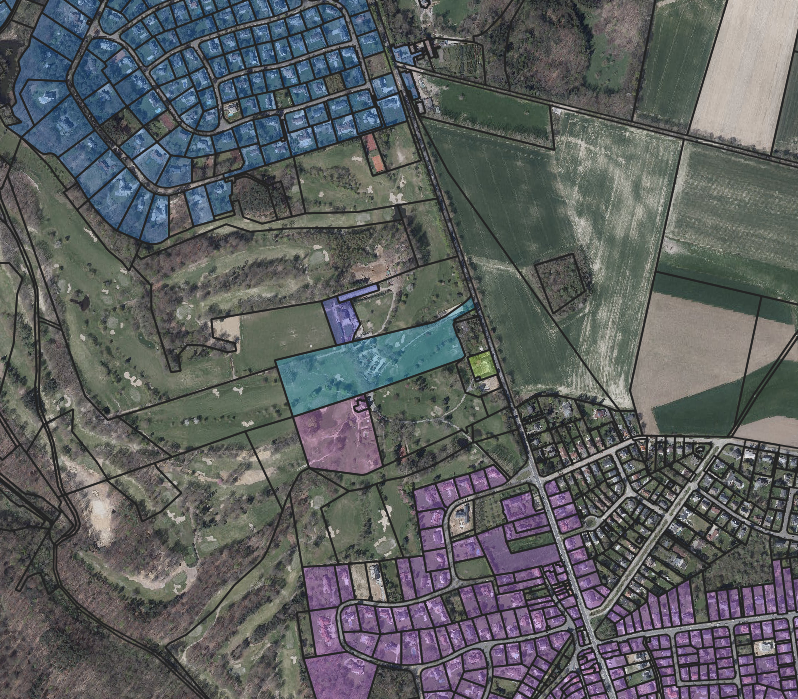

# Buffer

I use a buffer to join together the different polygons in the cluster.

In [18]:
t11_buffer=f'''

select dropTable(NULL,'t11_buffer',1);

create table t11_buffer as
select cc, castToMultiPolygon(st_buffer(st_buffer(geometry,{buffer}),-{buffer})) as geometry
from t10_connected_components
;

create unique index i11_buffer on t11_buffer(cc);

'''

An alternative query could be:
```
create table t11_buffer as
select cc, castToMultiPolygon(st_makePolygon(st_exteriorRing(geometry))) as geometry
from (
      select cc, castToMultiPolygon(st_buffer(st_buffer(geometry,{buffer}),-{buffer})) as geometry
      from t10_connected_components
     )
;
```

In [19]:
db.database.executescript(t11_buffer)
db.recoverGeometry('t11_buffer')
db.createSpatialIndex('t11_buffer')

A few clusters (note the presence of isolated clusters):
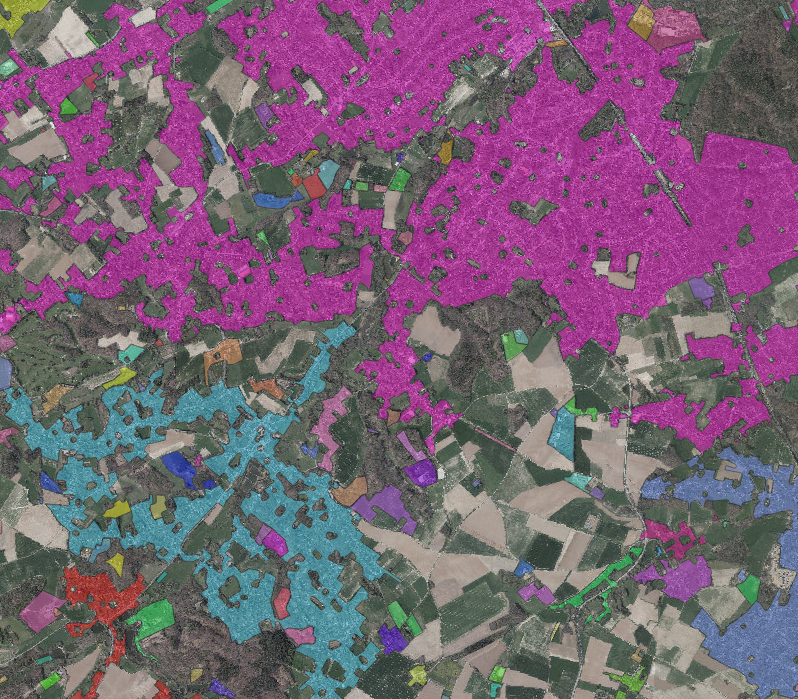

A zoom on one of the cluster:
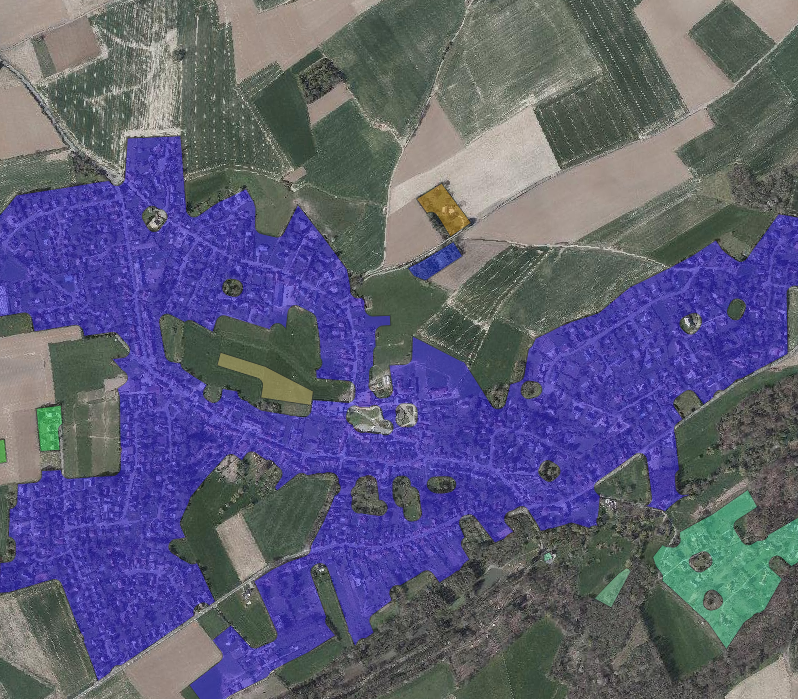

Some very large clusters:
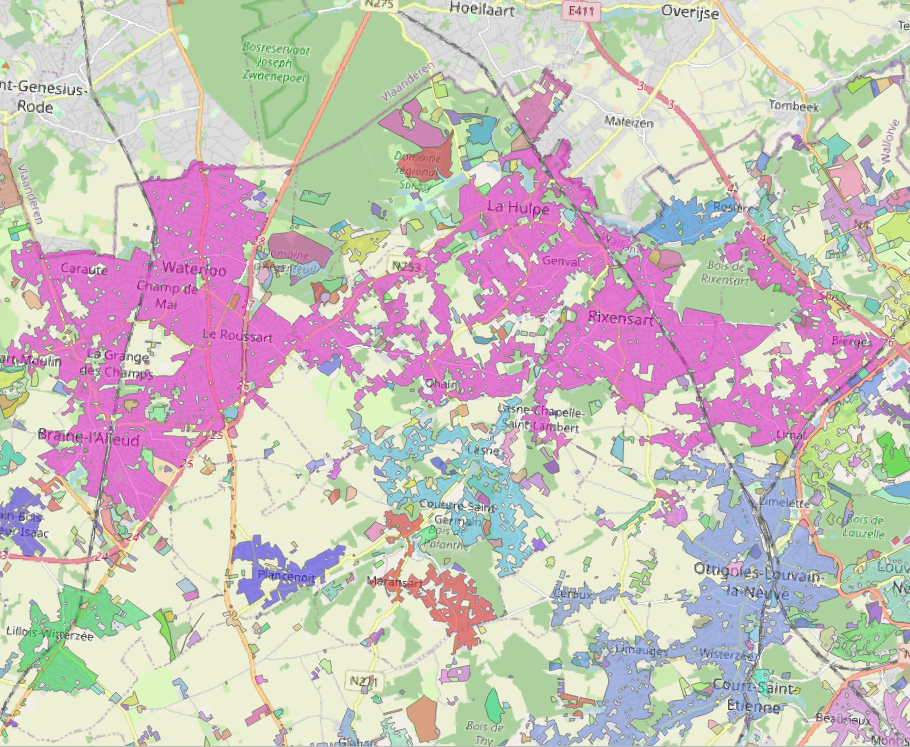

Placenoit is a small, isolated cluster:
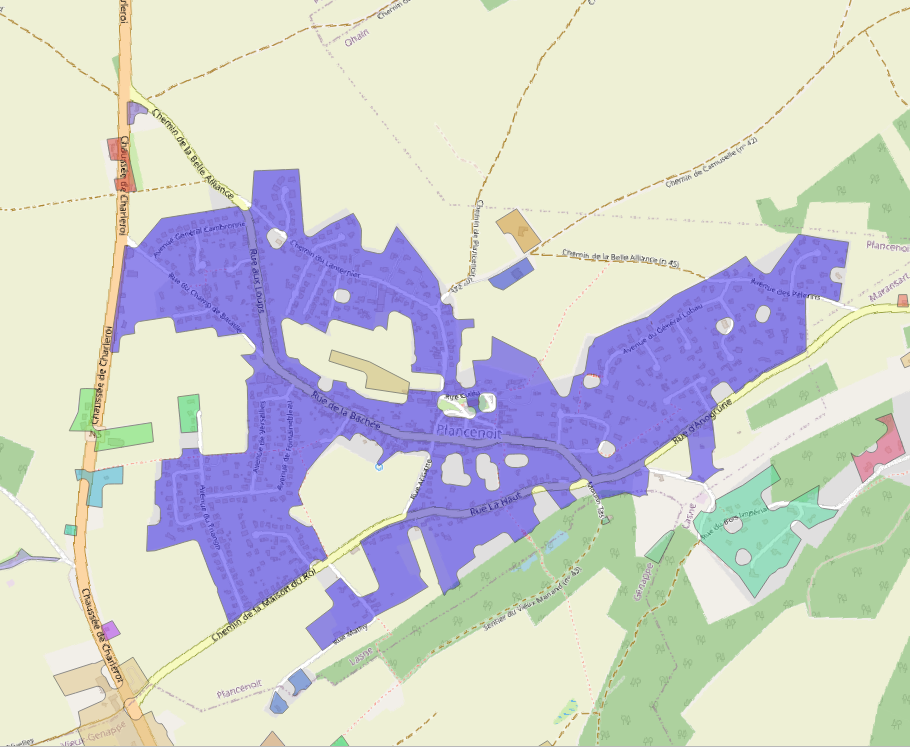

Note that this cluster look like the one identified by OpenStreetMap:
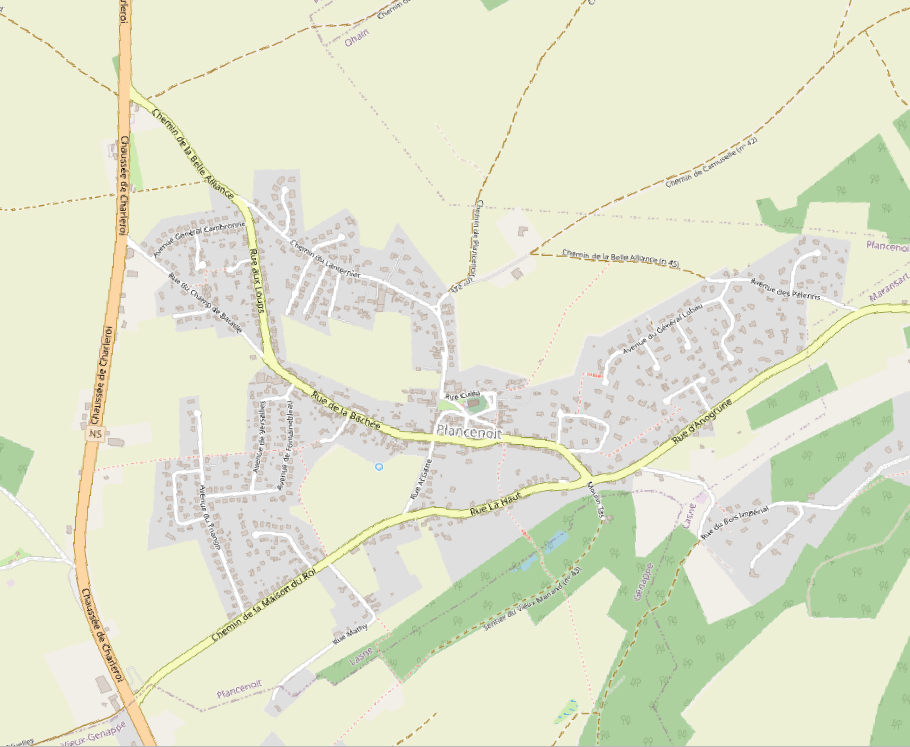

In [20]:
db.close()